# Implémentation du CBOW avec Keras

Dans ce notebook, vous allez implémenter et entraîner le CBOW avec Keras.

L'implémentation va se diviser en quatre parties : 
- Construire le vocabulaire du corpus
- Construire un générateur de CBOW (contexte, cible)
- Construire l'architecture du modèle CBOW
- Entraîner le modèle
- Obtenir les words embeddings (options 1, 2 et 3)
- Visualiser les mots similaires

# Importation de fichiers

Avant de commencer veuillez importer les fichiers du TP via le lien ci-dessous :

https://drive.google.com/drive/folders/1S8u7-8dnsRCawJ8tAg1VzB4TvTdcbN7Q?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Importation des packages

In [3]:
# Import Python libraries and helper functions (in utils2) 
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from gdrive.MyDrive.TP_6.utils2 import sigmoid, get_batches, compute_pca, get_dict

from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Importations des données

In [4]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('gdrive/MyDrive/TP_6/shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60933 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


# Pré-traitement des données

In [5]:


tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(data)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in data]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5772
Vocabulary Sample: [('the', 1), ('and', 2), ('i', 3), ('to', 4), ('of', 5), ('my', 6), ('that', 7), ('in', 8), ('you', 9), ('a', 10)]


# Création du dataset d'entraînement

Extraire les mots de contextes et les mots centrés. 
Créer un dataset avec ces mots 

In [6]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

# Initialisation du modèle

Vous pouvez utiliser la fonction *Embedding* afin de transformer vos mots en vecteurs.

Documentation de la fonction [ici](https://keras.io/api/layers/core_layers/embedding/).

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            577200    
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5772)              582972    
Total params: 1,160,172
Trainable params: 1,160,172
Non-trainable params: 0
_________________________________________________________________
None


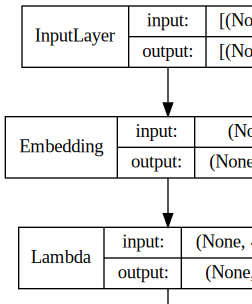

In [7]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

# Entraînement

In [ ]:
for epoch in range(1, 2):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 10000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 10000 (context, word) pairs


# Extraction du word embeddings option 1

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

# Extraction du word embeddings option 2

In [ ]:
weights = cbow.get_weights()[1]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

# Extraction du word embeddings option 3

# Afficher les mots similaires

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words